In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#### LOAD AND TRANSFORM

## Download: ONLY ONCE!
#os.system('wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz')
#os.system('tar xvzf data.tgz')
#####


# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(791, 250, 250, 3)
(791,)
(784, 250, 250, 3)
(784,)


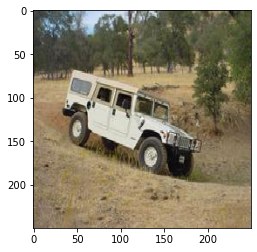

In [3]:
## View some images
plt.imshow(x_train[3,:,:,: ] )
plt.show()

In [4]:
## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

In [5]:
batch_size = 32
num_classes = 20
epochs = 150

## Labels
y_train=y_train-1

y_test=y_test-1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

datagen = ImageDataGenerator(
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=45,
    zoom_range=[1.0,1.2],
    horizontal_flip=True
)

In [6]:
vgg16 = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(250, 250, 3),
    classes=1000,
    classifier_activation="softmax"
)

In [7]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0     

In [8]:
#############################
###      BILINEAR        ####
#############################

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001
    
def scheduler_fine(epoch):
    if epoch < 25:
        return .0001
    elif epoch < 50:
        return 0.00001
    else:
        return 0.000001

set_lr = LRS(scheduler)
set_lr_fine = LRS(scheduler_fine)

def outer_product(x):
    phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])		# Einstein Notation  [batch,31,31,depth] x [batch,31,31,depth] -> [batch,depth,depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]**2])	        # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.divide(phi_I,x[0].shape[1]**2)								  # Divide by feature map size [sizexsize]

    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))		# Take signed square root of phi_I
    z_l2 = tf.nn.l2_normalize(y_ssqrt)								              # Apply l2 normalization
    return z_l2

In [9]:
conv = vgg16.get_layer('block4_pool') 
d1 = Dropout(0.5)(conv.output)   ## Why??
d2 = Dropout(0.5)(conv.output)   ## Why??

x = Lambda(outer_product, name='outer_product')([d1,d2])

predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=predictions)
  
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 250, 250, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 250, 250, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 125, 125, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [10]:
vgg16.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)   

## TRAINING with DA and LRA
history=model.fit_generator(
    datagen.flow(x_train, y_train,batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size, 
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[set_lr],
    verbose=1
)

vgg16.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)   

## TRAINING with DA and LRA
history=model.fit_generator(
    datagen.flow(x_train, y_train,batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size, 
    epochs=epochs-10,
    validation_data=(x_test, y_test),
    callbacks=[set_lr_fine],
    verbose=1
)

/home/vicdoja/anaconda3/envs/tf_env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
24/24 [==============================] - 27s 968ms/step - loss: 5.5886 - accuracy: 0.0532 - val_loss: 3.4112 - val_accuracy: 0.2283
Epoch 2/10
24/24 [==============================] - 21s 835ms/step - loss: 3.0551 - accuracy: 0.2090 - val_loss: 2.5982 - val_accuracy: 0.2423
Epoch 3/10
24/24 [==============================] - 21s 831ms/step - loss: 2.3694 - accuracy: 0.3146 - val_loss: 2.9797 - val_accuracy: 0.2742
Epoch 4/10
24/24 [==============================] - 20s 828ms/step - loss: 2.0266 - accuracy: 0.4246 - val_loss: 2.1785 - val_accuracy: 0.3202
Epoch 5/10
24/24 [==============================] - 21s 842ms/step - loss: 1.6315 - accuracy: 0.5354 - val_loss: 2.4582 - val_accuracy: 0.3163
Epoch 6/10
24/24 [==============================] - 21s 834ms/step - loss: 1.6840 - accuracy: 0.5172 - val_loss: 2.4258 - val_accuracy: 0.3329
Epoch 7/10
24/24 [==============================] - 21s 843ms/step - loss: 1.4004 - accuracy: 0.5771 - val_loss: 2.2418 - val_accuracy: 0.4681

KeyboardInterrupt: 